*Created: 09/09/24*
**Authors:** Ismael Mendoza

Here I run multiple chains on different noise realizations of the same low SNR galaxy and check convergence, efficiency of the resulting samples.

I sample initial parameters from the prior not from a ball. 

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_VISIBLE_DEVICES']

'0'

In [2]:
import jax 
import jax.numpy as jnp
from jax.scipy import stats

from jax import random
from jax import jit as jjit

In [3]:
import galsim 
import jax_galsim as xgalsim

2024-09-09 10:02:13.439137: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-09-09 10:02:24.317259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import blackjax
import numpy as np 

import arviz as az
import chainconsumer as cc
import matplotlib.pyplot as plt

import numpyro
import time
from datetime import date
import numpy as np

import matplotlib.pyplot as plt 

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from tqdm import tqdm

In [6]:
from functools import partial

In [7]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [8]:
import bpd
from bpd.draw import add_noise
from bpd.measure import get_snr


In [9]:
from bpd.chains import inference_loop

In [10]:
jax.devices()

[CudaDevice(id=0)]

In [11]:
GPU = jax.devices('gpu')[0]

In [12]:
jax.config.update("jax_default_device", GPU)

In [13]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

In [14]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # https://gist.github.com/thriveth/8560036

# Drawing methods

In [15]:
# constant galaxy parameters to fit 
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN= 53
PSF_HLR = 0.7

LOG_FLUX = 4.5
HLR = 0.9
G1 = 0.05
G2 = 0.0
X=0.
Y=0.

TRUE_PARAMS = {'f': LOG_FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2, 'x': X, 'y': Y}

In [16]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shift(dx=X, dy=Y)
    gal = gal.shear(g1=G1, g2=G2)
    
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

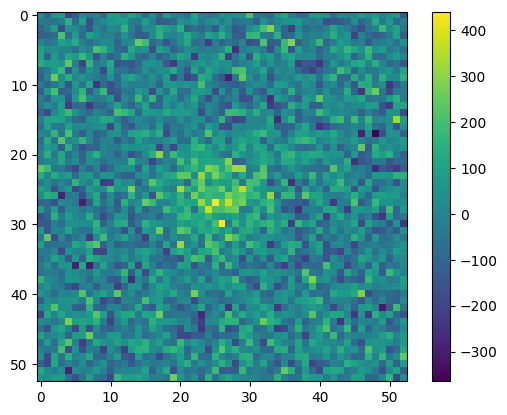

In [17]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [18]:
print(get_snr(im_nn, BACKGROUND))

18.25107


In [19]:
from functools import partial
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)
PIXEL_SCALE_GPU = jax.device_put(PIXEL_SCALE, device=GPU)
TEN_GPU = jnp.array(10., device=GPU)
ONE_GPU = jnp.array(1., device=GPU)
PSF_HLR_GPU = jnp.array(PSF_HLR, device=GPU)
SLEN_GPU = jnp.array(SLEN, device=GPU)

def draw_gal(f, hlr, g1, g2, x, y):
    # x, y arguments in pixels
    gal = xgalsim.Gaussian(flux=TEN_GPU**f, half_light_radius=hlr)
    gal = gal.shift(dx=x*PIXEL_SCALE_GPU, dy=y*PIXEL_SCALE_GPU)
    gal = gal.shear(g1=g1, g2=g2)
    
    psf = xgalsim.Gaussian(flux=ONE_GPU, half_light_radius=PSF_HLR_GPU)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN, ## if I change this to SLEN_GPU, get error
                               scale=PIXEL_SCALE_GPU,
                            )
    return image.array

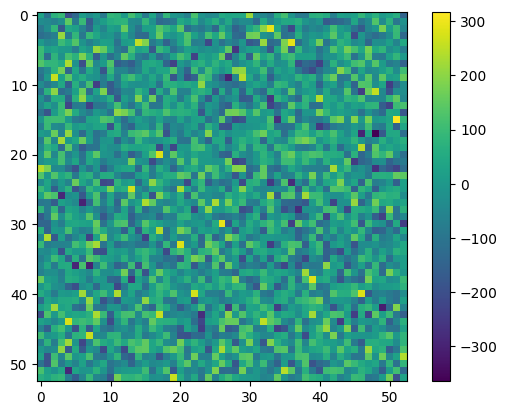

In [20]:
# sanity check 1
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

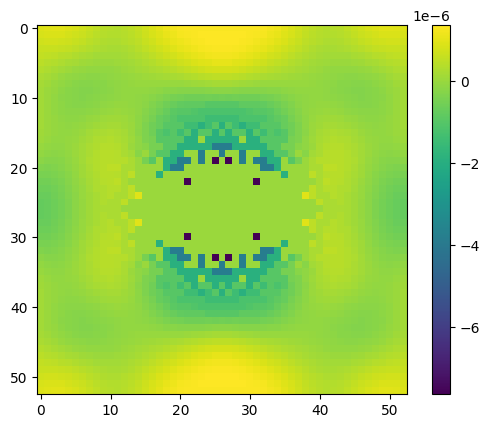

In [21]:
# sanity check 2
res = im_nn - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

In [22]:
# timing makes sense
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)

draw_gal_jitted = jax.jit(draw_gal)
draw_gal_jitted(**TRUE_PARAMS_GPU)

%timeit draw_gal_jitted(**TRUE_PARAMS_GPU) # ~ 4x fast
%timeit _draw_gal()

108 μs ± 1.65 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
466 μs ± 28.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Setup logprob

In [23]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {'f': (-1., 9.), 'hlr': (0.01, 5.0), 
          'g1': (-0.7, 0.7), 'g2': (-0.7, 0.7), 
          'x': 1,  # sigma (in pixels)
          'y':1 # sigma (in pixels)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)

In [24]:
def prior_sample(rng_key, n:int):
    f = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['f'][0], maxval=BOUNDS_GPU['f'][1])
    hlr = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['hlr'][0], maxval=BOUNDS_GPU['hlr'][1])
    g1 = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['g1'][0], maxval=BOUNDS_GPU['g1'][1])
    g2 = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['g2'][0], maxval=BOUNDS_GPU['g2'][1])
    x = random.normal(rng_key, (n,)) * BOUNDS_GPU['x'] # mean = 0 , sigma=1
    y = random.normal(rng_key, (n,)) * BOUNDS_GPU['y'] # mean = 0, sigma=1
    
    return {'f': f, 'hlr': hlr, 'g1': g1, 'g2': g2, 'x': x, 'y': y} 

In [25]:
# sample from ball around some dictionary of true params
def sample_ball(rng_key, center_params:dict):
    new = {} 
    keys = random.split(rng_key, len(center_params.keys()))
    rng_key_dict = {p:k for p,k in zip(center_params, keys)}
    for p in center_params:
        centr = center_params[p]
        if p == 'f':
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.25, maxval=centr + 0.25)
        elif p == 'hlr':
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.2, maxval=centr + 0.2)
        elif p in {'g1', 'g2'}:
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.025, maxval=centr + 0.025)
        elif p in {'x', 'y'}:
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.5, maxval=centr + 0.5)
    return new
        


In [26]:
def _logprob_fn(params, data):    
    #prior
    prior = jnp.array(0., device=GPU) 
    for p in ('f', 'hlr', 'g1', 'g2'): # uniform priors
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2-b1)
        
    for p in ('x', 'y'): # normal
        sigma = BOUNDS_GPU[p]
        prior += stats.norm.logpdf(params[p], sigma)

    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)


# Benchmark 3.1

In [27]:
# what parameter space do we want to explore?
N_WARMUPS = 500 # seems good enough
MAX_DOUBLINGS = 5 # maybe good enough, 10 is a lot and probably need to explore what is good in terms of warmpu first, otherwise one chain can easily get stuck
N_CHAINS = 100

In [28]:
N_SAMPLES = 1000

## Run

In [29]:
SEED = 42

In [30]:
results = [] # just for n_chains

In [31]:
# get data
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED), 
                 n=25) # maximum number of chains, 25*4, subsample below
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (25, 53, 53)


In [32]:
# base rng key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)}


In [43]:
# we create all the random keys we will need
prior_key, sample_key, warmup_key = random.split(rng_key, 3)

ball_keys = random.split(ball_key, max(N_CHAINS))
warmup_keys = random.split(warmup_key, max(N_CHAINS))
sample_keys = random.split(sample_key, max(N_CHAINS))

warmup_keys.shape



(100,)

In [44]:
all_init_positions = jax.vmap(sample_ball, in_axes=(0, None))(ball_keys, TRUE_PARAMS_GPU) # since we run 4 chains per noise realization in this case per object
all_init_positions['f'].shape

(100,)

In [45]:
# vmap only rng_key
def do_warmup(rng_key, init_position:dict, data):
    
    _logdensity = partial(_logprob_fn, data=data)
    
    warmup = blackjax.window_adaptation(
    blackjax.nuts, _logdensity, progress_bar=False, 
        is_mass_matrix_diagonal=False, 
        max_num_doublings=MAX_DOUBLINGS, 
        initial_step_size=0.1, 
        target_acceptance_rate=0.90 # default
    )    
    return warmup.run(rng_key, init_position, N_WARMUPS) # (init_states, tuned_params), adapt_info

    
def do_inference(rng_key, init_state, data, step_size:float, inverse_mass_matrix):
    _logdensity = partial(_logprob_fn, data=data)
    kernel = blackjax.nuts(_logdensity, step_size=step_size, inverse_mass_matrix=inverse_mass_matrix, 
                           max_num_doublings=MAX_DOUBLINGS).step
    return inference_loop(rng_key, init_state, kernel=kernel, n_samples=N_SAMPLES) # state, info
    


In [46]:

# can be resued as we fixed warmup and samples and doublings
_run_warmup =  jax.vmap(
                        jax.jit(
                                do_warmup
                        ), in_axes=(0, 0, 0)

)
_run_inference = jax.vmap(
                        jax.jit(
                                do_inference
                        ), in_axes=(0, 0, 0, 0, 0)
)


print('n_chains:')
for ii, n_chains in enumerate(N_CHAINS):
    d = {} # save results in this dictionary
    print(n_chains)

        
    # subset what we need for the n_chains
    _wkeys = warmup_keys[:n_chains]
    _skeys = sample_keys[:n_chains]
    _init_positions = {p:q[:n_chains] for p,q in all_init_positions.items()}
    _data = data_gpu[:n_chains]


    if ii == 0:
        # compilation times
        t1 = time.time()
        (_init_states, _tuned_params), _ = jax.block_until_ready(_run_warmup(_wkeys, _init_positions, _data))            
        t2 = time.time()
        d['warmup_comp_time'] = t2 - t1 

        t1 = time.time()
        _ = jax.block_until_ready(_run_inference(_skeys, _init_states, _data, 
                                                            _tuned_params['step_size'], 
                                                            _tuned_params['inverse_mass_matrix']))
        t2 = time.time()
        d['inference_comp_time'] = t2 - t1 

    # run times
    t1 = time.time()
    (init_states, tuned_params), adapt_info = jax.block_until_ready(_run_warmup(_wkeys, _init_positions, _data))
    t2 = time.time()
    d['warmup_run_time'] = t2 - t1 

    t1 = time.time()
    states, infos = jax.block_until_ready(_run_inference(_skeys, init_states, _data, 
                                                         tuned_params['step_size'], 
                                                         tuned_params['inverse_mass_matrix']
                                                        ))
    t2 = time.time()
    d['inference_run_time'] = t2 - t1 

    # save states and info for future reference
    d['states'] = states
    d['info'] = infos
    d['adapt_info'] = adapt_info
    
    results.append(d)
print('DONE!')

n_chains:
1
5
10
20
30
40
50
60
70
80
90
100
DONE!


In [47]:
results[-1]['states'].position['f'].shape

(100, 1000)

In [48]:
results_dict = {n_chains:results[ii] for ii, n_chains in enumerate(N_CHAINS)}

## save run

In [49]:
jnp.save(f'results_benchmark-v2_4_{SEED}.npy', results_dict)

## Diagnostic plots

In [50]:
seed = 45
d = jnp.load(f'results_benchmark-v2_4_{seed}.npy', allow_pickle=True)[()]

In [51]:
N_CHAINS = np.array(list(d.keys()))
N_CHAINS

array([  1,   5,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [53]:
d[100]['states'].position['g1'].shape # check

(100, 1000)

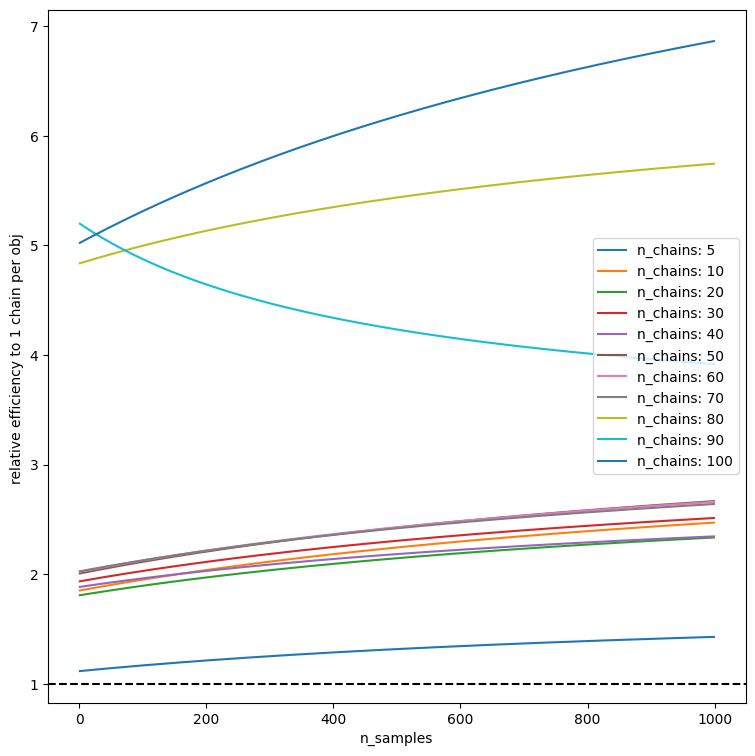

In [56]:
# assuming these results hold for arbitrary number of objects
# let's do just # samples later do effective samples

# we will compute the relative efficiency per objt as a function of samples. 
# i.e. time to get n_samlpes / per_obj w/ N_chains / (time to get n_samples per_obj w/ 1 chain)


# pr obb comparison only valid with > 100 with multilpe number of objects


plt.figure(figsize=(9, 9))

n_samples = np.arange(1, 1000)

times = {n:[] for n in N_CHAINS}
for n in N_CHAINS:
    # warmup is fixed regardless of how many samples we want
    # inference is for 1000 samples per obj always so divide by 1000
    t = (d[n]['warmup_run_time'] + (d[n]['inference_run_time'] / 1000 * n_samples) ) / n# for simplicity assume each chain targets a different objec, even though each 4 chains share 1 obj
    times[n] = t
    
for n in N_CHAINS[1:]:
    plt.plot(n_samples, times[1] / times[n], label=f'n_chains: {n}')
    
plt.legend()

plt.ylabel("relative efficiency to 1 chain per obj ")
plt.xlabel("n_samples")

plt.axhline(1.0, color='k', linestyle='--')

In [71]:
 ((d[1]['warmup_run_time'] + d[1]['inference_run_time']) * 200)  / ( (d[100]['warmup_run_time'] + d[100]['inference_run_time']) * 2)

6.864240767559214

Text(0.5, 0, 'n_chains')

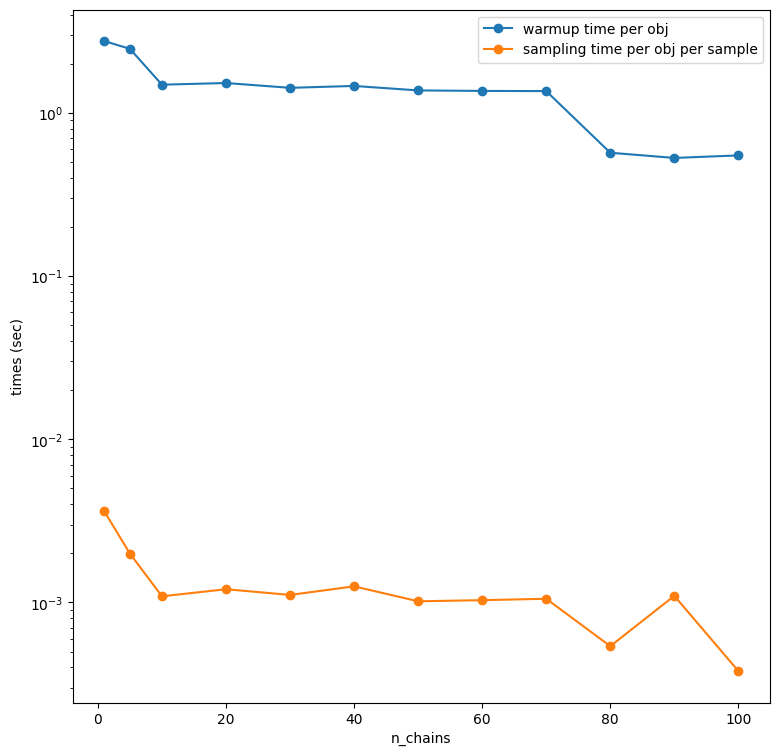

In [75]:
# time per sample per object
plt.figure(figsize=(9, 9))


times1 = [] 
times2 = []
for n in N_CHAINS: 
    warmup_time_per_obj = d[n]['warmup_run_time']  / n
    sampling_time_per_sample_per_obj = d[n]['inference_run_time'] / 1000  / n
    times1.append(warmup_time_per_obj)
    times2.append(sampling_time_per_sample_per_obj)

    
plt.plot(N_CHAINS, times1, '-o', label='warmup time per obj')
plt.plot(N_CHAINS, times2, '-o', label='sampling time per obj per sample')

plt.yscale('log')

plt.legend()

plt.ylabel("times (sec)")
plt.xlabel("n_chains")

# plt.axhline(1.0, color='k', linestyle='--')

In [81]:
N_CHAINS

array([  1,   5,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [88]:
times1[-1], times1[0], times2[-1], times2[0]

(0.5494381737709045,
 2.7579619884490967,
 0.00037983115196228023,
 0.0036207664012908934)

In [90]:
times1[0] * 200 + times2[0] * 200 * 10

558.8339304924011

In [89]:
times1[-1] * 200 + times2[-1] * 200 * 10

110.64729705810547

Text(0, 0.5, 'total time to get n_samples for every obj (sec)')

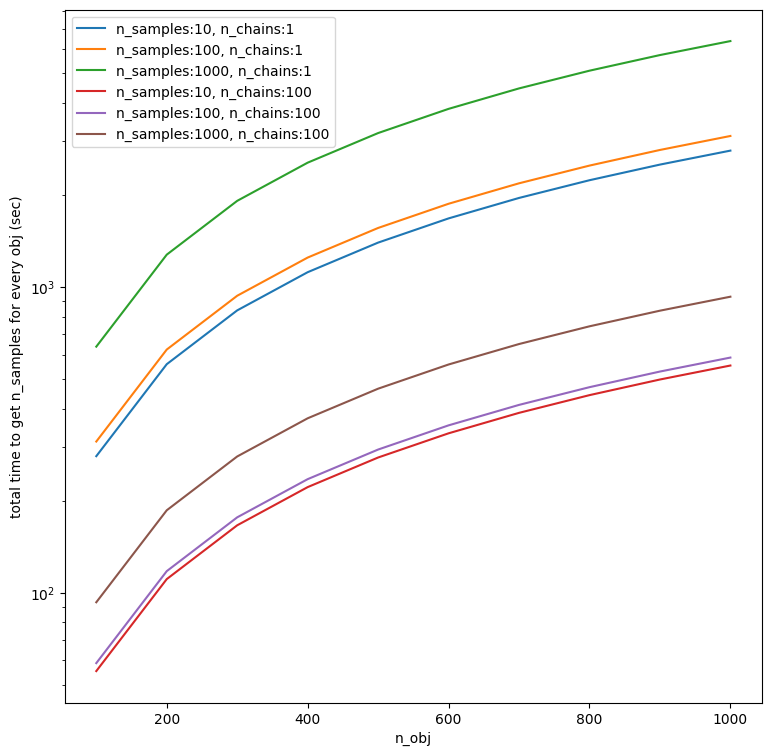

In [106]:
# total time as a function of n_obj for different number of samples for 100 chains

# time per sample per object
plt.figure(figsize=(9, 9))

n_objs = np.arange(100, 1001, 100)
n_samples = np.array([10, 100, 1000])

times1 = [] 
times2 = []
for n in N_CHAINS: 
    warmup_time_per_obj = d[n]['warmup_run_time']  / n
    sampling_time_per_sample_per_obj = d[n]['inference_run_time'] / 1000  / n
    times1.append(warmup_time_per_obj)
    times2.append(sampling_time_per_sample_per_obj)

for nc in (1, 100):
    
    wt = times1[0] if nc ==1 else times1[-1]
    rt = times2[0] if nc ==1 else times2[-1]

    for ns in n_samples:
        tt = (wt * n_objs) + (ns * rt * n_objs)
        
        plt.plot(n_objs, tt, label=f'n_samples:{ns}, n_chains:{nc}')

plt.yscale("log")
plt.legend()

plt.xlabel("n_obj")
plt.ylabel("total time to get n_samples for every obj (sec)")

Text(0, 0.5, 'time per obj as a function of samples (s)')

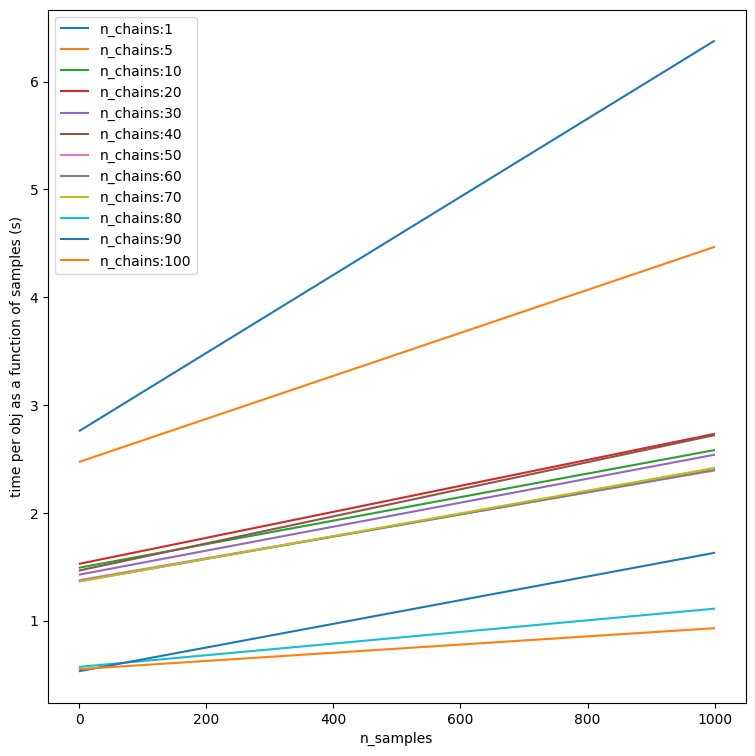

In [111]:
# time per obj. as a function of n_samples 
# different chains

# time per sample per object
plt.figure(figsize=(9, 9))

n_samples = np.arange(1, 1000, 1)

times1 = [] 
times2 = []
for n in N_CHAINS: 
    warmup_time_per_obj = d[n]['warmup_run_time']  / n
    sampling_time_per_sample_per_obj = d[n]['inference_run_time'] / 1000  / n
    times1.append(warmup_time_per_obj)
    times2.append(sampling_time_per_sample_per_obj)
    
    
for ii, n in enumerate(N_CHAINS):
    wt = times1[ii]
    rt =times2[ii]
    tt = wt + rt * n_samples # per obj
    plt.plot(n_samples, tt, label=f'n_chains:{n}')

# plt.yscale("log")
plt.legend()

plt.xlabel("n_samples")
plt.ylabel("time per obj as a function of samples (s)")

In [117]:
d[1]['warmup_run_time'] * 100 + d[1]['inference_run_time'] * 100

637.872838973999

Text(0, 0.5, 'efficiency compared to running 1 chain')

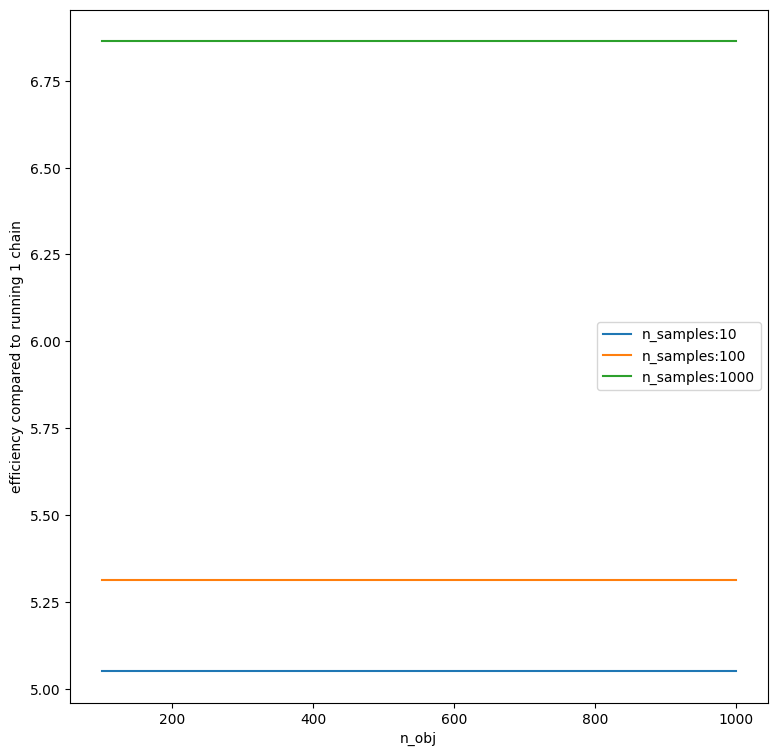

In [99]:
# same but relative efficiency
# time per sample per object
plt.figure(figsize=(9, 9))

n_objs = np.arange(100, 1001, 100)
n_samples = np.array([10, 100, 1000])

times1 = [] 
times2 = []
for n in N_CHAINS: 
    warmup_time_per_obj = d[n]['warmup_run_time']  / n
    sampling_time_per_sample_per_obj = d[n]['inference_run_time'] / 1000  / n
    times1.append(warmup_time_per_obj)
    times2.append(sampling_time_per_sample_per_obj)


wt1 = times1[0]
wt2 = times1[-1]
rt1 = times2[0]
rt2 = times2[-1]


for ns in n_samples:
    tt1 = (wt1 * n_objs)+ (ns * rt1 * n_objs) 
    tt2 = (wt2 * n_objs)+ (ns * rt2 * n_objs) 

    plt.plot(n_objs, tt1 / tt2, label=f'n_samples:{ns}')

plt.legend()

plt.xlabel("n_obj")
plt.ylabel("efficiency compared to running 1 chain")

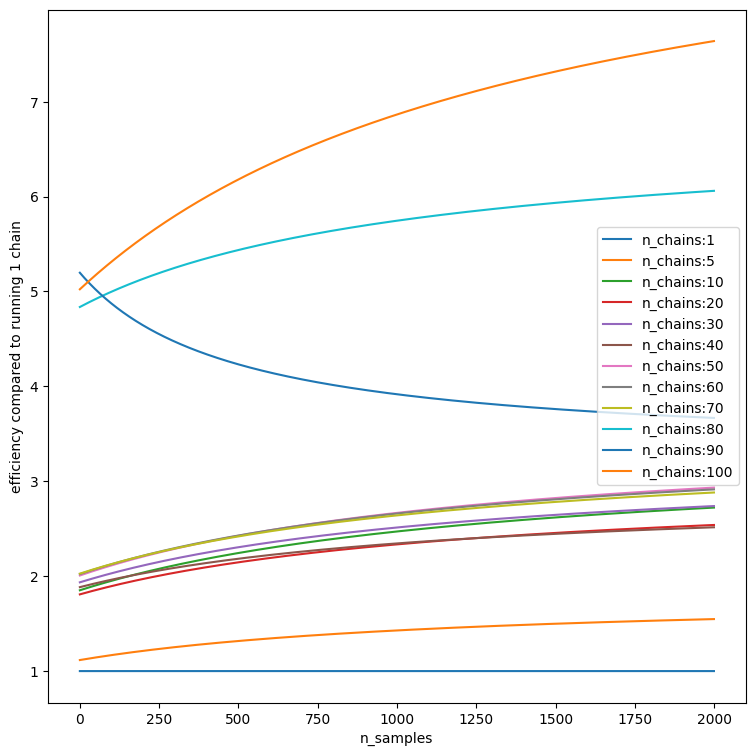

In [107]:
# same but relative efficiency
# time per sample per object
plt.figure(figsize=(9, 9))

n_samples = np.arange(1, 2000, 1)

times1 = [] 
times2 = []
for n in N_CHAINS: 
    warmup_time_per_obj = d[n]['warmup_run_time']  / n
    sampling_time_per_sample_per_obj = d[n]['inference_run_time'] / 1000  / n
    times1.append(warmup_time_per_obj)
    times2.append(sampling_time_per_sample_per_obj)


wt1 = times1[0]
rt1 = times2[0]

for ii, n in enumerate(N_CHAINS):
    
    tt1 = wt1+ (n_samples * rt1) 
    tt2 = times1[ii]+ (n_samples * times2[ii] )

    plt.plot(n_samples, tt1 / tt2, label=f'n_chains:{n}')


plt.xlabel("n_samples")
plt.ylabel("efficiency compared to running 1 chain")
plt.legend()

In [94]:
d[100]['warmup_run_time'] + d[100]['inference_run_time']

92.92693257331848

In [109]:
times1[0]/ times1[-1], times2[0] / times2[-1]

(5.019603879214744, 9.532568307221046)